# OSSE / Trade Space Capability for NOAA's Future Mission Design

Task 1 Deliverable Report

Paul T. Grogan <paul.grogan@asu.edu>

Contributors: Julia Cairns <jcairns@stevens.edu> and Zackary Horton <zhorton@stevens.edu>

## Introduction

This report provides analysis metrics computed by the Tradespace Analysis Tool for Constellations (TAT-C) to describe the current NOAA polar-orbiting LEO constellation for validation purposes, to provide narrative on TAT-C modeling assumptions, and demonstrate the analysis workflow. This work has been performed under the project "OSSE / Trade Space Capability for NOAA's Future Mission Design".

The following sections provide background on the TAT-C tool, describe the constellation model, and summarize analysis results. This document is structured as a Jupyter notebook which combines narrative text and executable code for greater transparency and reproducibility.

## Background

### TAT-C Capabilities

The [Tradespace Analysis Tool for Constellations (TAT-C)](https://github.com/code-lab-org/tatc) is an open-source Python software package for early-stage mission modeling, simulation, and analysis for Earth-observing satellite constellations. It was developed with support from the NASA Advanced Information Systems Technology (AIST) program. This project uses TAT-C version 3 which is the third major revision to the tool.

TAT-C simulates the orbital motion and observability conditions of satellite-based instruments and produces data such as orbit track, ground track (projected sensor area), and observation records. Analysis methods compute key mission performance metrics such as revisit time (time between subsequent observations of a fixed point) and data latency (time from observation of a fixed point until the first available downlink opportunity) to support trade studies.

The overall objective of this project is to use TAT-C as a pre-processor for the Advanced Systems Performance Evaluation tool for NOAA (ASPEN) Sensor Constellation/Performance (SCP) table. SCP columns that can be informed by TAT-C analysis include (descriptions from ASPEN-91 definition tables):

 * Temporal Refresh: "Time between observations at a location, i.e., time to observe the geographic coverage region D."
 * Data Latency: "Time from 'image taken' to full relay of data to a ground station." (_Note: TAT-C does not consider processing time as a part of data latency; in other words, an additional factor must be added to the TAT-C results._)

TAT-C models instrument observability constraints rather geophysical variables. Instruments selected for this report consist of infrared and microwave sounders and visual/infrared imagers which correspond to SCP rows such as:

 * Infrared Sounder: Air temperature profiles, Cloud top temperature, Sea surface temperature, Specific humidity, Land surface temperature
 * Microwave Sounder: Air temperature profiles, Specific humidity
 * Visual/Infrared Imager: Cloud cover, Cloud top temperature, Fire radiative power, Sea surface temperature, Snow cover

### TAT-C Configuration

This document uses TAT-C version 3.4.0 which is currently in development on the main branch of [GitHub](https://github.com/code-lab-org/tatc). Technical documentation is available at [ReadTheDocs](https://tatc.readthedocs.io/en/latest/).

To install TAT-C including extra dependencies required for this notebook, run: 

`pip install tatc[examples]` 

using the pip installer or

`conda install -c conda-forge tatc[examples]` 

using the conda-forge installer.

## Constellation Specification

NOAA currently operates Earth-observing satellites in low Earth orbit (LEO) and geostationary orbit (GEO). As TAT-C analysis emphasizes time-varying obsevations due to orbit propagation, this analysis focuses on the LEO constellation consisting of 5th Generation Polar Operational Environmental Satellites (POES: NOAA-15, -18 and -19) and Joint Polar Satellite System (JPSS: Suomi NPP, NOAA-20, and -21).

### Instruments

This section models microwave sounder, infrared sounder, and visible/infrared imager instruments used NOAA's current Earth-observing LEO constellation. The following instrument specifications are based on publicly-available data from the World Meteorological Organization's [Observing Systems Capability Analysis and Review (OSCAR) Tool](https://space.oscar.wmo.int):

|Instrument                                             | Swath (km) | Dist (km) |NOAA-15|NOAA-18|NOAA-19| SNPP  |NOAA-20|NOAA-21|
|-------------------------------------------------------|------------|-----------|-------|-------|-------|-------|-------|-------|
|Advanced Microwave Sounding Unit A (AMSU-A)            |    2250    |    48     |   X   |   X   |   X   |       |       |       |
|Advanced Microwave Sounding Unit B (AMSU-B)            |    2250    |    16     |   X   |       |       |       |       |       |
|Microwave Humidity Sounding (MHS)                      |    2180    |    16     |       |   X   |   X   |       |       |       |
|Advanced Technology Microwave Sounder (ATMS)           |    2200    |    16     |       |       |       |   X   |   X   |   X   |
|High-resolution Infra Red Sounder / 3 (HIRS/3)         |    2200    |    42     |   X   |       |       |       |       |       |
|High-resolution Infra Red Sounder / 4 (HIRS/4)         |    2200    |    42     |       |   X   |   X   |       |       |       |
|Cross-track Infrared Sounder (CrIS)                    |    2200    |    48     |       |       |       |   X   |   X   |   X   |
|Advanced Very High Resolution Radiometer / 3 (AVHRR/3) |    2900    |    6.6    |   X   |   X   |   X   |       |       |       |
|Visible/Infrared Imager Radiometer Suite (VIIRS)       |    3000    |    11.9   |       |       |       |   X   |   X   |   X   |

TAT-C models instruments based on an angular field of regard which can be computed based on swath width and altitude (assumed to be 850 km). A minimum access time helps to adjust along-track swath based on a provided sampling distance.

In [3]:
from tatc.schemas import PointedInstrument
from tatc.utils import (
    swath_width_to_field_of_regard,
    swath_width_to_field_of_view,
    along_track_distance_to_access_time,
)

ref_altitude = 850e3
ref_inclination = 98.6

amsu_a = PointedInstrument(
    name="AMSU-A",
    field_of_regard=swath_width_to_field_of_regard(ref_altitude, 2250e3),
    min_access_time=along_track_distance_to_access_time(
        ref_altitude, ref_inclination, 48e3
    ),
    fixed_access_time=True,
    cross_track_field_of_view=swath_width_to_field_of_view(ref_altitude, 2250e3),
    along_track_field_of_view=swath_width_to_field_of_view(ref_altitude, 48e3 * 10),
    is_rectangular=True,
)
amsu_b = PointedInstrument(
    name="AMSU-B",
    field_of_regard=swath_width_to_field_of_regard(ref_altitude, 2250e3),
    min_access_time=along_track_distance_to_access_time(
        ref_altitude, ref_inclination, 16e3
    ),
    fixed_access_time=True,
    cross_track_field_of_view=swath_width_to_field_of_view(ref_altitude, 2250e3),
    along_track_field_of_view=swath_width_to_field_of_view(ref_altitude, 16e3 * 10),
    is_rectangular=True,
)
mhs = PointedInstrument(
    name="MHS",
    field_of_regard=swath_width_to_field_of_regard(ref_altitude, 2180e3),
    min_access_time=along_track_distance_to_access_time(
        ref_altitude, ref_inclination, 16e3
    ),
    fixed_access_time=True,
    cross_track_field_of_view=swath_width_to_field_of_view(ref_altitude, 2180e3),
    along_track_field_of_view=swath_width_to_field_of_view(ref_altitude, 16e3 * 10),
    is_rectangular=True,
)
atms = PointedInstrument(
    name="ATMS",
    field_of_regard=swath_width_to_field_of_regard(ref_altitude, 2200e3),
    min_access_time=along_track_distance_to_access_time(
        ref_altitude, ref_inclination, 16e3
    ),
    fixed_access_time=True,
    cross_track_field_of_view=swath_width_to_field_of_view(ref_altitude, 2200e3),
    along_track_field_of_view=swath_width_to_field_of_view(ref_altitude, 16e3 * 10),
    is_rectangular=True,
)
hirs_3 = PointedInstrument(
    name="HIRS/3",
    field_of_regard=swath_width_to_field_of_regard(ref_altitude, 2200e3),
    min_access_time=along_track_distance_to_access_time(
        ref_altitude, ref_inclination, 42e3
    ),
    fixed_access_time=True,
    cross_track_field_of_view=swath_width_to_field_of_view(ref_altitude, 2200e3),
    along_track_field_of_view=swath_width_to_field_of_view(ref_altitude, 42e3 * 10),
    is_rectangular=True,
)
hirs_4 = PointedInstrument(
    name="HIRS/4",
    field_of_regard=swath_width_to_field_of_regard(ref_altitude, 2200e3),
    min_access_time=along_track_distance_to_access_time(
        ref_altitude, ref_inclination, 42e3
    ),
    fixed_access_time=True,
    cross_track_field_of_view=swath_width_to_field_of_view(ref_altitude, 2200e3),
    along_track_field_of_view=swath_width_to_field_of_view(ref_altitude, 42e3 * 10),
    is_rectangular=True,
)
cris = PointedInstrument(
    name="CrIS",
    field_of_regard=swath_width_to_field_of_regard(ref_altitude, 2200e3),
    min_access_time=along_track_distance_to_access_time(
        ref_altitude, ref_inclination, 48e3
    ),
    fixed_access_time=True,
    cross_track_field_of_view=swath_width_to_field_of_view(ref_altitude, 2200e3),
    along_track_field_of_view=swath_width_to_field_of_view(ref_altitude, 48e3 * 10),
    is_rectangular=True,
)
avhrr_3 = PointedInstrument(
    name="AVHRR/3",
    field_of_regard=swath_width_to_field_of_regard(ref_altitude, 2900e3),
    min_access_time=along_track_distance_to_access_time(
        ref_altitude, ref_inclination, 6.6e3
    ),
    fixed_access_time=True,
    cross_track_field_of_view=swath_width_to_field_of_view(ref_altitude, 2900e3),
    along_track_field_of_view=swath_width_to_field_of_view(ref_altitude, 6.6e3 * 10),
    is_rectangular=True,
)
viirs = PointedInstrument(
    name="VIIRS",
    field_of_regard=swath_width_to_field_of_regard(ref_altitude, 3000e3),
    min_access_time=along_track_distance_to_access_time(
        ref_altitude, ref_inclination, 11.9e3
    ),
    fixed_access_time=True,
    cross_track_field_of_view=swath_width_to_field_of_view(ref_altitude, 3000e3),
    along_track_field_of_view=swath_width_to_field_of_view(ref_altitude, 11.9e3 * 10),
    is_rectangular=True,
)


microwave_sounders = ["AMSU-A", "AMSU-B", "MHS", "ATMS"]
infrared_sounders = ["HIRS/3", "HIRS/4", "CrIS"]
visible_infrared_imagers = ["AVHRR/3", "VIIRS"]

instrument_groups = [
    ("Microwave Sounder", microwave_sounders),
    ("Infrared Sounder", infrared_sounders),
    ("Visible/Infrared Imager", visible_infrared_imagers),
]

### Satellite Specifications

This section models satellites participating in NOAA's current LEO constellation. The following satellite specifications are based on publicly-available data from the World Meteorological Organization's [OSCAR Tool](https://space.oscar.wmo.int) and [CelesTrak](https://celestrak.org) General Perturbations (GP) data as of September 2023:

| Satellite | Ref. Altitude (km) | Ref. Equator Crossing Time | TLE (as of September 2023)                                            |
|-----------|--------------------|----------------------------|-----------------------------------------------------------------------|
| NOAA-15   | 813                | 7:28 Descending            | `1 25338U 98030A   23269.59105138  .00000329  00000+0  15478-3 0  9996` <br /> `2 25338  98.6000 296.8875 0010693  24.0363 336.1314 14.26396144319462` |
| NOAA-18   | 854                | 8:05 Descending            | `1 28654U 05018A   23269.53943895  .00000353  00000+0  21270-3 0  9992` <br /> `2 28654  98.9023 343.4078 0015291  93.7598 266.5322 14.13013890945796` |
| NOAA-19   | 870                | 7:29 Descending            | `1 33591U 09005A   23269.59670054  .00000303  00000+0  18745-3 0  9996` <br /> `2 33591  99.0896 317.0977 0013142 320.6654  39.3561 14.12828015754000` |
| SNPP      | 833                | 13:25 Ascending            | `1 37849U 11061A   23269.53617392  .00000219  00000+0  12472-3 0  9998` <br /> `2 37849  98.7093 206.5497 0001068  60.2627  50.3317 14.19571070617323` |
| NOAA-20   | 834                | 13:25 Ascending            | `1 43013U 17073A   23269.47916028  .00000193  00000+0  11197-3 0  9992` <br /> `2 43013  98.7173 206.3490 0001136 107.6181 252.5119 14.19567911303349` |
| NOAA-21   | 824                | 13:30 Ascending            | `1 54234U 22150A   23269.49507492  .00000244  00000+0  13662-3 0  9990` <br /> `2 54234  98.7211 205.8776 0001553  96.6823 263.4530 14.19552111 45429` |

Each satellite is assigned an orbit specification and all constituent instruments.

In [4]:
from tatc.schemas import Satellite, TwoLineElements

noaa_15 = Satellite(
    name="NOAA-15",
    orbit=TwoLineElements(
        tle=[
            "1 25338U 98030A   23269.59105138  .00000329  00000+0  15478-3 0  9996",
            "2 25338  98.6000 296.8875 0010693  24.0363 336.1314 14.26396144319462",
        ]
    ),
    instruments=[amsu_a, amsu_b, hirs_3, avhrr_3],
)

noaa_18 = Satellite(
    name="NOAA-18",
    orbit=TwoLineElements(
        tle=[
            "1 28654U 05018A   23269.53943895  .00000353  00000+0  21270-3 0  9992",
            "2 28654  98.9023 343.4078 0015291  93.7598 266.5322 14.13013890945796",
        ]
    ),
    instruments=[amsu_a, mhs, hirs_4, avhrr_3],
)

noaa_19 = Satellite(
    name="NOAA-19",
    orbit=TwoLineElements(
        tle=[
            "1 33591U 09005A   23269.59670054  .00000303  00000+0  18745-3 0  9996",
            "2 33591  99.0896 317.0977 0013142 320.6654  39.3561 14.12828015754000",
        ]
    ),
    instruments=[amsu_a, mhs, hirs_4, avhrr_3],
)

snpp = Satellite(
    name="SNPP",
    orbit=TwoLineElements(
        tle=[
            "1 37849U 11061A   23269.53617392  .00000219  00000+0  12472-3 0  9998",
            "2 37849  98.7093 206.5497 0001068  60.2627  50.3317 14.19571070617323",
        ]
    ),
    instruments=[atms, cris, viirs],
)

noaa_20 = Satellite(
    name="NOAA-20",
    orbit=TwoLineElements(
        tle=[
            "1 43013U 17073A   23269.47916028  .00000193  00000+0  11197-3 0  9992",
            "2 43013  98.7173 206.3490 0001136 107.6181 252.5119 14.19567911303349",
        ]
    ),
    instruments=[atms, cris, viirs],
)

noaa_21 = Satellite(
    name="NOAA-21",
    orbit=TwoLineElements(
        tle=[
            "1 54234U 22150A   23269.49507492  .00000244  00000+0  13662-3 0  9990",
            "2 54234  98.7211 205.8776 0001553  96.6823 263.4530 14.19552111 45429",
        ]
    ),
    instruments=[atms, cris, viirs],
)

satellites = [noaa_15, noaa_18, noaa_19, snpp, noaa_20, noaa_21]

satellite_groups = [
    ("NOAA-15", ["NOAA-15"]),
    ("NOAA-18", ["NOAA-18"]),
    ("NOAA-19", ["NOAA-19"]),
    ("SNPP", ["SNPP"]),
    ("NOAA-20", ["NOAA-20"]),
    ("NOAA-21", ["NOAA-21"]),
    ("POES+JPSS (6)", ["NOAA-15", "NOAA-18", "NOAA-19", "SNPP", "NOAA-20", "NOAA-21"]),
    ("JPSS (3)", ["SNPP", "NOAA-20", "NOAA-21"]),
    ("JPSS (2)", ["NOAA-20", "NOAA-21"]),
]

### Ground Network Specification

This section models the ground network representative of the Joint Polar Satellite System (JPSS) Common Ground System (CGS) supporting NOAA's current earth-observing LEO constellation. The following ground stations use approximate attributes describing geolocation and a minimum elevation angle constraint collected from publicly-available sources:

| Station     | Latitude (deg) | Longitude (deg) | Elevation (m) | Min. Elevation Angle (deg) |
|-------------|----------------|-----------------|---------------|----------------------------|
| McMurdo     | -77.846323     | 166.668235      | 10            | 5                          |
| Svalbard    | 78.229772      | 15.407786       | 450           | 5                          |
| Fairbanks   | 64.97381       | -147.50575      | 400           | 5                          |
| White Sands | 32.5007        | -106.6086       | 1200          | 5                          |
| Troll       | -72.016667     | 2.533333        | 1275          | 5                          |

In [5]:
from tatc.schemas import GroundStation

mcmurdo = GroundStation(
    name="McMurdo",
    latitude=-77.846323,
    longitude=166.668235,
    elevation=150,
    min_elevation_angle=5,
)
svalbard = GroundStation(
    name="Svalbard",
    latitude=78.229772,
    longitude=15.407786,
    elevation=450,
    min_elevation_angle=5,
)
fairbanks = GroundStation(
    name="Fairbanks",
    latitude=64.97381,
    longitude=-147.50575,
    elevation=400,
    min_elevation_angle=5,
)
white_sands = GroundStation(
    name="White Sands",
    latitude=32.5007,
    longitude=-106.6086,
    elevation=1200,
    min_elevation_angle=5,
)
troll = GroundStation(
    name="Troll",
    latitude=-72.016667,
    longitude=2.533333,
    elevation=1275,
    min_elevation_angle=5,
)

stations = [mcmurdo, svalbard, fairbanks, white_sands, troll]

## Analysis

### Sample Point Generation

TAT-C performs spatial analysis across a set of representative sample points. This report considers a global domain with samples distributed following a [Fibonacci lattice](https://doi.org/10.1007/s11004-009-9257-x) which distributes points more uniformly over the surface compared to a cubed sphere grid. This report uses a typical sample distance of 1000 km which results in 649 sample points.

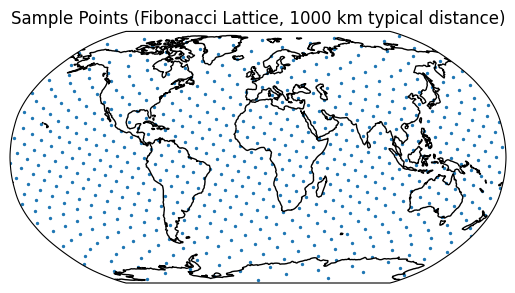

In [6]:
from tatc.generation import generate_fibonacci_lattice_points
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

# generate a sample point distribution with 1000 km typical sample distance
points_df = generate_fibonacci_lattice_points(1000e3)

# plot the sample points
ax = plt.axes(projection=ccrs.Robinson())
points_df.plot(ax=ax, markersize=2, transform=ccrs.PlateCarree())
ax.coastlines()
plt.title("Sample Points (Fibonacci Lattice, 1000 km typical distance)")
plt.show()

As TAT-C simulates space-based observations of each sample point, its computational complexity grows proportionally to the number of sample points. Furthermore, the number of sample points grows exponentially with the inverse sample distance for a Fibonacci lattice. Some analyses can leverage domain symmetry (e.g., most observation statistics do not vary by longitude) to reduce computational complexity; however, this is not possible for data latency analysis which relies on the relative location of samples and ground stations.

### Observation Collection

TAT-C simulates observations of each sample point by satellite-based instruments over a specified analysis period, set here to 30 days to enable statistical characterization of features occuring on a 24-hour timescale. TAT-C uses the Simplified General Perturbations (SGP4) model implemented in [Skyfield](https://rhodesmill.org/skyfield/) for orbit propagation based on General Perturbations (GP) elements sets currently in Two Line Element (TLE) format. SGP4 propagation accuracy is on the order of kilometers (for perspective, orbital velocity at 800 km altitude is about 7.5 km/s, so the temporal accuracy is on the order of seconds) and degrades after the GP collection date (epoch). TAT-C uses an event detection function from Skyfield to identify the rise, culmination, and set times for observations of a sample point based on a minimum elevation angle constraint computed based on the instrument altitude and swath. The analysis is highly-parallelizable: each sample point and satellite-instrument pair can be handled independently, resulting in significant speedup on multi-core systems. 

Observation records are stored in a large dataframe that contains the sample point identifier and location, observing satellite-instrument pair, start/epoch/end (i.e., rise/culmination/set) time of the observation, and azimuth/elevation of the satellite at culmination. The resulting observation dataframe for this report totals more than 1 million records and can be completed in about 3 minutes on a AMD Ryzen 9 5950X 16-core CPU.

In [8]:
from tatc.analysis import collect_observations
from tatc.schemas import Point

from datetime import datetime, timedelta, timezone
from joblib import Parallel, delayed
import pandas as pd

# convert the sample points dataframe to TAT-C format
points = points_df.apply(
    lambda r: Point(id=r.point_id, latitude=r.geometry.y, longitude=r.geometry.x),
    axis=1,
)

# define the analysis period start and end
start = datetime(year=2023, month=9, day=15, hour=0, minute=0, tzinfo=timezone.utc)
end = start + timedelta(days=30)

# parallel process observations for all points/satellites/instruments
obs_db_list = Parallel(n_jobs=-1)(
    delayed(collect_observations)(
        point,
        satellite,
        start,
        end,
        i,
    )
    for point in points
    for satellite in satellites
    for i, _ in enumerate(satellite.instruments)
)

# merge the parallel-processed observation dataframes into a single dataframe
obs_df = pd.concat(obs_db_list, ignore_index=True)

display(obs_df)

point_id                       geometry  ...    sat_alt      sat_az
0               0        POINT Z (0 -85.50765 0)  ...  41.555392  329.804289
1               0        POINT Z (0 -85.50765 0)  ...  57.948148  356.935528
2               0        POINT Z (0 -85.50765 0)  ...  54.588762  332.117049
3               0        POINT Z (0 -85.50765 0)  ...  47.283703  307.260957
4               0        POINT Z (0 -85.50765 0)  ...  38.807478  282.269726
...           ...                            ...  ...        ...         ...
1086876       648  POINT Z (174.9689 83.64523 0)  ...  57.667133  137.979430
1086877       648  POINT Z (174.9689 83.64523 0)  ...  67.911397  163.609690
1086878       648  POINT Z (174.9689 83.64523 0)  ...  70.330714  189.054654
1086879       648  POINT Z (174.9689 83.64523 0)  ...  63.774822  213.237656
1086880       648  POINT Z (174.9689 83.64523 0)  ...  51.394369  237.028548

[1086881 rows x 9 columns]

### Revisit Analysis

TAT-C defines revisit (refresh) as the average temporal period between obsevations of a fixed point. Revisit period of a single satellite for a fixed point is not perfectly periodic due to orbital dynamics and surface geometry. Revisit period of a constellations of satellites is even more complex due to interacting effects between multiple orbits.

TAT-C queries the observation dataframe to compute key average revisit time. Filters can restrict the participating satellites and/or instruments to suit particular analysis needs. Data aggregation combines overlapping observations (e.g., across multiple instruments on one satellite or across satellites for coincident obsevations). Data reduction computes time-averaged statistics for each sample point. Finally, spatial aggregation computes the harmonic mean to characterize the domain.

The following example shows the analysis workflow for revisit time across all microwave sounder instruments (AMSU-A, AMSU-B, MHS, ATMS) and all satellites (NOAA-15, -18, -19, -20, -21, and SNPP). The average revisit time shows strong spatial dependence on latitude, characteristic of sun-synchronous orbits, ranging from about 0.5 hr near the poles to around 2.5 hr near the equator. The harmonic mean computed across all points shows the characteristic revisit time to be 1.57 hr for the constellation.

In [9]:
from tatc.analysis import aggregate_observations, reduce_observations
from scipy import stats

# aggregate observations to combine overlapping observations
mw_agg_df = aggregate_observations(obs_df[obs_df.instrument.isin(microwave_sounders)])
# reduce observations to time-averaged statistics for each sample point
mw_red_df = reduce_observations(mw_agg_df)
mw_red_df["revisit_hr"] = mw_red_df.apply(
    lambda r: r["revisit"] / timedelta(hours=1), axis=1
)
# compute the harmonic mean revisit time
mw_rev_hmean = stats.hmean(mw_red_df["revisit_hr"])

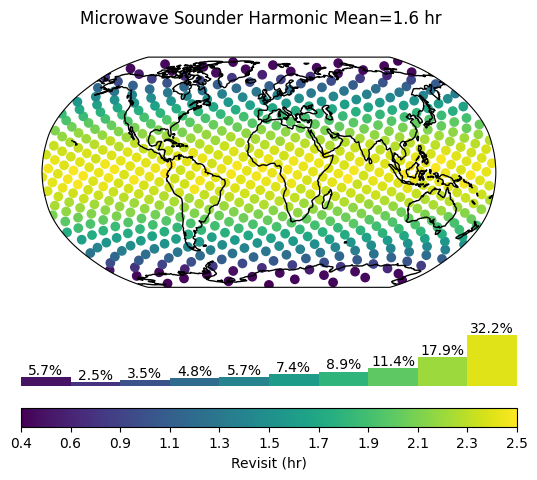

In [20]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import StrMethodFormatter
import numpy as np

fig = plt.figure()
gs = GridSpec(nrows=3, ncols=1, figure=fig, height_ratios=[3, 1, 0.25])
axs = [
    plt.subplot(gs[0, 0], projection=ccrs.Robinson()),
    plt.subplot(gs[1, 0]),
    plt.subplot(gs[2, 0]),
]
cmap = plt.colormaps["viridis"]
plt.suptitle(f'Microwave Sounder Harmonic Mean={stats.hmean(mw_red_df["revisit_hr"]):.1f} hr')

data = mw_red_df["revisit_hr"]
values, bins, bars = axs[1].hist(data, weights=np.ones(len(data)) / len(data))
centers = 0.5 * (bins[:-1] + bins[1:])
colors = (centers - bins.min()) / (bins.max() - bins.min())
for c, p in zip(colors, bars):
    plt.setp(p, "facecolor", cmap(c))
axs[1].bar_label(bars, fmt="{:.1%}")
axs[1].set_xlim(bins.min(), bins.max())
axs[1].set_ylim(0, values.max() * 1.5)
axs[1].axis("off")
mw_red_df.plot(
    ax=axs[0],
    column="revisit_hr",
    cmap=cmap,
    vmin=bins.min(),
    vmax=bins.max(),
    legend=True,
    legend_kwds={
        "label": "Revisit (hr)",
        "orientation": "horizontal",
        "cax": axs[2],
        "ticks": bins,
        "format": StrMethodFormatter("{x:.1f}"),
    },
    transform=ccrs.PlateCarree(),
)
axs[0].coastlines()
axs[0].set_global()
plt.show()

Similar analysis can be automated for various combinations of satellites and instruments. The following table evaluates the harmonic mean revisit time of each instrument group (microwave sounder, infrared sounder, visual imager, and infrared imager) for each satellite individually and as integrated constellations. Again, the script is highly paralellizable to take advantage of multi-core systems.

In [11]:
from tatc.analysis import aggregate_observations, reduce_observations
from joblib import Parallel, delayed
from scipy import stats


def get_harmonic_mean_revisit(satellite_group, instrument_group, bins=None):
    sat_label, satellites = satellite_group
    inst_label, instruments = instrument_group
    agg_df = aggregate_observations(
        obs_df[obs_df.satellite.isin(satellites) & obs_df.instrument.isin(instruments)]
    )
    red_df = reduce_observations(agg_df)
    red_df["revisit_hr"] = red_df.apply(
        lambda r: r["revisit"] / timedelta(hours=1), axis=1
    )
    return {
        "satellites": sat_label,
        "instruments": inst_label,
        "revisit": stats.hmean(red_df["revisit_hr"]),
    }


# parallel process results for all satellite groups and microwave sounder
results = pd.DataFrame(
    Parallel(n_jobs=-1)(
        delayed(get_harmonic_mean_revisit)(satellite_group, instrument_group)
        for satellite_group in satellite_groups
        for instrument_group in instrument_groups
    )
)

display(results)

satellites              instruments    revisit
0         NOAA-15        Microwave Sounder   9.805718
1         NOAA-15         Infrared Sounder  10.022862
2         NOAA-15  Visible/Infrared Imager   7.602518
3         NOAA-18        Microwave Sounder   9.408604
4         NOAA-18         Infrared Sounder   9.624216
5         NOAA-18  Visible/Infrared Imager   7.275431
6         NOAA-19        Microwave Sounder   9.366972
7         NOAA-19         Infrared Sounder   9.578180
8         NOAA-19  Visible/Infrared Imager   7.233896
9            SNPP        Microwave Sounder   9.815683
10           SNPP         Infrared Sounder   9.817996
11           SNPP  Visible/Infrared Imager   7.180087
12        NOAA-20        Microwave Sounder   9.868845
13        NOAA-20         Infrared Sounder   9.872109
14        NOAA-20  Visible/Infrared Imager   7.241739
15        NOAA-21        Microwave Sounder   9.841913
16        NOAA-21         Infrared Sounder   9.844890
17        NOAA-21  Visible/Infrared Imager   7.216900
18  POES+JPSS (6)        Microwave Sounder   1.570438
19  POES+JPSS (6)         Infrared Sounder   1.589167
20  POES+JPSS (6)  Visible/Infrared Imager   1.158931
21       JPSS (3)        Microwave Sounder   3.198781
22       JPSS (3)         Infrared Sounder   3.199720
23       JPSS (3)  Visible/Infrared Imager   2.304135
24       JPSS (2)        Microwave Sounder   4.861515
25       JPSS (2)         Infrared Sounder   4.863091
26       JPSS (2)  Visible/Infrared Imager   3.534830

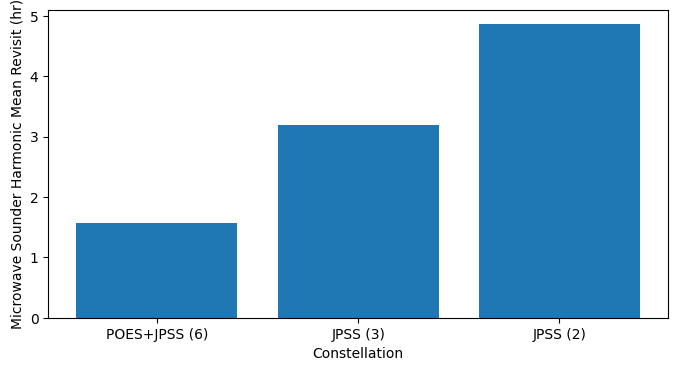

In [12]:
plt.figure(figsize=(8, 4))

filter = (results.satellites.str.contains("\(")) & (
    results.instruments == "Microwave Sounder"
)

plt.bar(results[filter]["satellites"], results[filter]["revisit"])
plt.ylabel("Microwave Sounder Harmonic Mean Revisit (hr)")
plt.xlabel("Constellation")
plt.show()

For comparison, OSCAR reports the following coverage capabilities for individual instruments:

 * "Near-global coverage twice/day": AMSU-A, AMSU-B, MHS, ATMS, HIRS/3, HIRS/4, and CrIS
 * "Global coverage twice/day (IR) or once/day (VIS)": AVHRR/3
 * "Global coverage twice/day (IR and day/night VIS/NIR channel) or once/day (VIS)": VIIRS

 These statements support the results shown above, noting the reported values which more closely reflect the domain maximum (characteristic of Equatorial regions) rather than the harmonic mean.

### Data Latency Analysis

TAT-C defines data latency as the average temporal period between obsevations of a fixed point and the first subsequent downlink opportunity to a ground station in the mission ground network. Notably, TAT-C does not consider the time required for data processing or other operational constraints such as downlink bandwidth, recorder storage capacity, local terrain elevation masks, or atmospheric attenuation.

Downlink opportunity records are computed similar to observations and stored in a large dataframe that contains the station name and location, satellite, and start/epoch/end (i.e., rise/culmination/set) time of the downlink opportunity. The resulting downlink dataframe for this report totals nearly 10k records.

In [13]:
from tatc.analysis import collect_downlinks

# parallel process the simulated downlinks for all stations and satellites
dls_db_list = Parallel(n_jobs=-1)(
    delayed(collect_downlinks)(
        station,
        satellite,
        start,
        end,
    )
    for station in stations
    for satellite in satellites
)

# merge the parallel-processed downlink dataframes into a single dataframe
dls_df = pd.concat(dls_db_list, ignore_index=True)

display(dls_df)

station  ...                               epoch
0     McMurdo  ...    2023-09-15 00:00:28.796391+00:00
1     McMurdo  ...    2023-09-15 01:39:16.695868+00:00
2     McMurdo  ...    2023-09-15 03:21:56.554853+00:00
3     McMurdo  ...    2023-09-15 05:04:21.930552+00:00
4     McMurdo  ...    2023-09-15 06:46:15.106386+00:00
...       ...  ...                                 ...
9850    Troll  ...    2023-10-14 15:57:35.740519+00:00
9851    Troll  ... 2023-10-14 17:37:20.025863500+00:00
9852    Troll  ...    2023-10-14 19:16:43.043892+00:00
9853    Troll  ... 2023-10-14 20:56:06.877405500+00:00
9854    Troll  ...    2023-10-14 22:35:53.525702+00:00

[9855 rows x 6 columns]

Data latency analysis uses the same obsevation dataframe from revisit analysis in conjunction with a the downlink opportunities. Computation of data latency matches the first future downlink opportunity to each obsevation. Downlink opportunities must have a start (rise) time after the end (set) time of an obsevation. Latency measures the epoch-to-epoch (culmination-to-culmination) time between obsevation and downlink opportunity.

In [14]:
from tatc.analysis import compute_latencies

# compute latencies for each observation
lat_df = compute_latencies(obs_df, dls_df)

display(lat_df)

point_id  ...                            observed
0             517  ...    2023-09-15 00:00:02.820692+00:00
1             364  ... 2023-09-15 00:00:06.285428500+00:00
2               2  ... 2023-09-15 00:00:08.981571500+00:00
3             637  ...    2023-09-15 00:00:09.574729+00:00
4             351  ...    2023-09-15 00:00:09.775130+00:00
...           ...  ...                                 ...
1086876       384  ... 2023-10-14 23:59:55.325580500+00:00
1086877       636  ...    2023-10-14 23:59:56.253189+00:00
1086878        27  ... 2023-10-14 23:59:56.870961500+00:00
1086879         2  ... 2023-10-14 23:59:58.263806500+00:00
1086880       628  ... 2023-10-14 23:59:58.272852500+00:00

[1086881 rows x 10 columns]

The following example shows the analysis workflow for data latency across all microwave sounder instruments (AMSU-A, AMSU-B, MHS, ATMS) and all satellites (NOAA-15, -18, -19, -20, -21, and SNPP). The average data latency shows a spatial dependence with larger values over the Antarctic region (where a full orbit period is required before downlink) and shorter values elsewhere (where half an orbit period is required). The mean value computed across all points shows the characteristic data latency to be 54.4 min for the constellation.

In [15]:
from tatc.analysis import reduce_latencies

# reduce latencies to time-averaged statistics for each sample point
mw_lat_red_df = reduce_latencies(lat_df[lat_df.instrument.isin(microwave_sounders)])
mw_lat_red_df["latency_min"] = mw_lat_red_df.apply(
    lambda r: r["latency"] / timedelta(minutes=1), axis=1
)
# compute the mean latency
mw_lat_mean = mw_lat_red_df["latency_min"].mean()

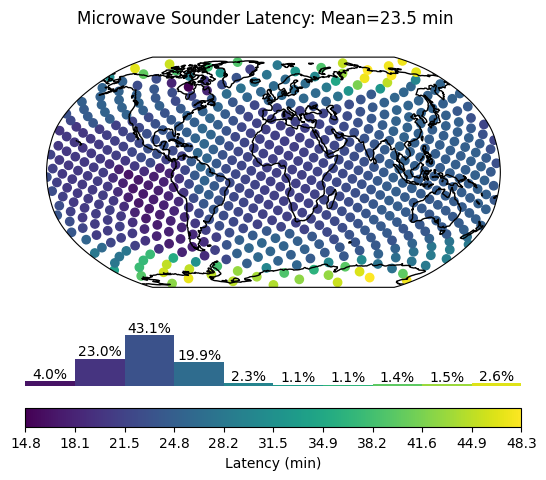

In [17]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import StrMethodFormatter
import numpy as np

fig = plt.figure()
gs = GridSpec(nrows=3, ncols=1, figure=fig, height_ratios=[3, 1, 0.25])
axs = [
    plt.subplot(gs[0, 0], projection=ccrs.Robinson()),
    plt.subplot(gs[1, 0]),
    plt.subplot(gs[2, 0]),
]
cmap = plt.colormaps["viridis"]
plt.suptitle(
    f'Microwave Sounder Latency: Mean={stats.hmean(mw_lat_red_df["latency_min"]):.1f} min'
)

data = mw_lat_red_df["latency_min"]
values, bins, bars = axs[1].hist(data, weights=np.ones(len(data)) / len(data))
centers = 0.5 * (bins[:-1] + bins[1:])
colors = (centers - bins.min()) / (bins.max() - bins.min())
for c, p in zip(colors, bars):
    plt.setp(p, "facecolor", cmap(c))
axs[1].bar_label(bars, fmt="{:.1%}")
axs[1].set_xlim(bins.min(), bins.max())
axs[1].set_ylim(0, values.max() * 1.5)
axs[1].axis("off")
mw_lat_red_df.plot(
    ax=axs[0],
    column="latency_min",
    cmap=cmap,
    vmin=bins.min(),
    vmax=bins.max(),
    legend=True,
    legend_kwds={
        "label": "Latency (min)",
        "orientation": "horizontal",
        "cax": axs[2],
        "ticks": bins,
        "format": StrMethodFormatter("{x:.1f}"),
    },
    transform=ccrs.PlateCarree(),
)
axs[0].coastlines()
axs[0].set_global()
axs[0].set_xlabel("Longitude (deg)")
axs[0].set_ylabel("Latitude (deg)")
plt.show()

Similar analysis can be automated for various combinations of satellites and instruments. The following table evaluates the mean data latency of each instrument group (microwave sounder, infrared sounder, visual imager, and infrared imager) for each satellite individually and as integrated constellations. Again, the script is highly paralellizable to take advantage of multi-core systems.

In [18]:
from tatc.analysis import reduce_latencies
from joblib import Parallel, delayed


def get_mean_latency(instrument_group, satellite_group):
    inst_label, instruments = instrument_group
    sat_label, satellites = satellite_group
    # reduce observations to time-averaged statistics for each sample point
    red_df = reduce_latencies(
        lat_df[
            (lat_df.satellite.isin(satellites)) & lat_df.instrument.isin(instruments)
        ]
    )
    red_df["latency_min"] = red_df.apply(
        lambda r: r["latency"] / timedelta(minutes=1), axis=1
    )
    return {
        "satellites": sat_label,
        "instruments": inst_label,
        "latency": red_df["latency_min"].mean(),
    }


# parallel process results for all satellite and instrument groups
results = pd.DataFrame(
    Parallel(n_jobs=-1)(
        delayed(get_mean_latency)(instrument_group, satellite_group)
        for instrument_group in instrument_groups
        for satellite_group in satellite_groups
    )
)
display(results)

satellites              instruments    latency
0         NOAA-15        Microwave Sounder  24.197649
1         NOAA-18        Microwave Sounder  24.577866
2         NOAA-19        Microwave Sounder  24.636859
3            SNPP        Microwave Sounder  24.360461
4         NOAA-20        Microwave Sounder  24.343698
5         NOAA-21        Microwave Sounder  24.336712
6   POES+JPSS (6)        Microwave Sounder  24.432395
7        JPSS (3)        Microwave Sounder  24.346959
8        JPSS (2)        Microwave Sounder  24.340184
9         NOAA-15         Infrared Sounder  24.162215
10        NOAA-18         Infrared Sounder  24.563789
11        NOAA-19         Infrared Sounder  24.628077
12           SNPP         Infrared Sounder  24.361382
13        NOAA-20         Infrared Sounder  24.343708
14        NOAA-21         Infrared Sounder  24.335593
15  POES+JPSS (6)         Infrared Sounder  24.402139
16       JPSS (3)         Infrared Sounder  24.346896
17       JPSS (2)         Infrared Sounder  24.339613
18        NOAA-15  Visible/Infrared Imager  24.733375
19        NOAA-18  Visible/Infrared Imager  25.080627
20        NOAA-19  Visible/Infrared Imager  25.141240
21           SNPP  Visible/Infrared Imager  24.957171
22        NOAA-20  Visible/Infrared Imager  24.937983
23        NOAA-21  Visible/Infrared Imager  24.939981
24  POES+JPSS (6)  Visible/Infrared Imager  24.967049
25       JPSS (3)  Visible/Infrared Imager  24.945010
26       JPSS (2)  Visible/Infrared Imager  24.938902

While no data is immediately available to directly validate data latency results, most JPSS products are available in near real time, measured as 3-6 hours from the raw data acquisition. Furthermore, the [JPSS Level 1 Requirements Document](https://www.nesdis.noaa.gov/s3/2022-03/L1RDS.pdf) specifies 80 minutes latency for most ATMS, CrIS, and VIIRS application packet products.

Analysis can also inspect the fractional load to each ground station.

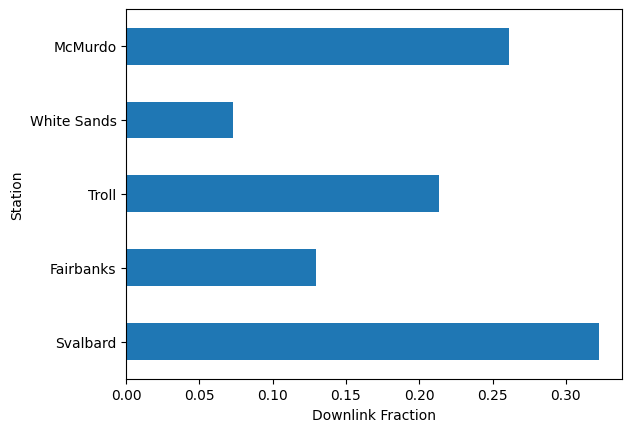

In [21]:
plt.figure()
lat_df["station"].value_counts(True).reindex(
    ["Svalbard", "Fairbanks", "Troll", "White Sands", "McMurdo"]
).plot(y="number", kind="barh")
plt.xlabel("Downlink Fraction")
plt.ylabel("Station")
plt.show()

## Conclusion

The report documents the application of TAT-C analysis procedures for NOAA's existing Earth-observing LEO satellites. Results show measurement of revisit time and data latency for microwave sounder, infrared sounder, and infrared/visual imager instruments for individual satellites and integrated constellations. Numerical results align with expected values. 

All results shown are reproducible using open-source tools and the inline code contained within this Jupyter notebook. This report has been executed in approximately 15 minutes on a personal computer workstation with a Intel i9-13900 processor and 32 GB memory. Underlying methods can 

Results will be applied to two further project tasks. First, the analysis procedures to measure revisit and data latency will be applied to evaluate performance of future constellations in a trade space exploration. Architectures of interest include both traditional polar-orbiting satellites as well as heterogeneous constellations including inclined orbits and proliferated constellations. Second, TAT-C ground track data will be used to define obsevable regions for more detailed analysis of obsevation quality (accuracy, resolution, etc.) through observing system simulation experiments (OSSEs) performed by ParOSSE.

## Appendix

This appendix provides additional geospatial analysis results for reference. POES refers to NOAA-15, -18, and -19. JPSS refers to NOAA-20, -21, and SNPP. JPSS (2) refers to NOAA-20 and -21.

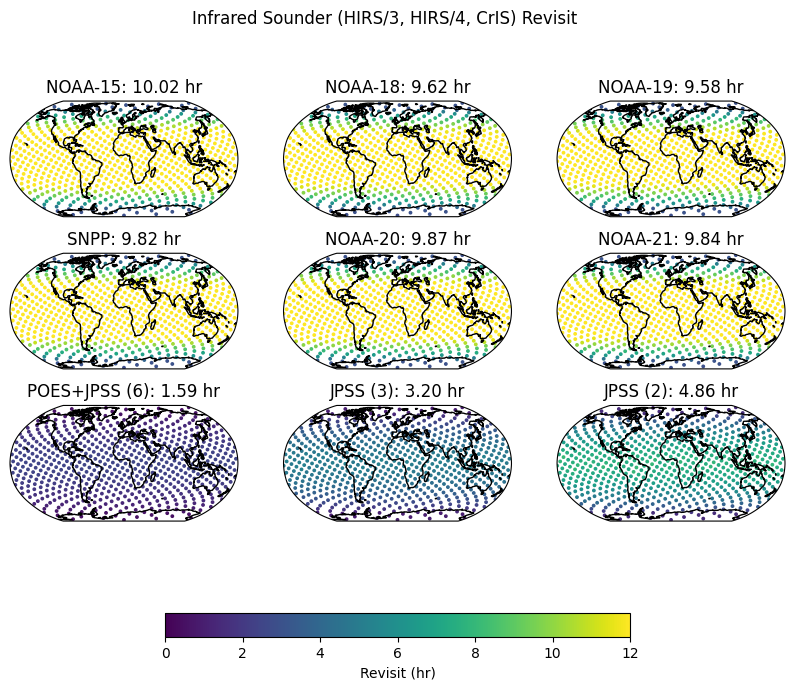

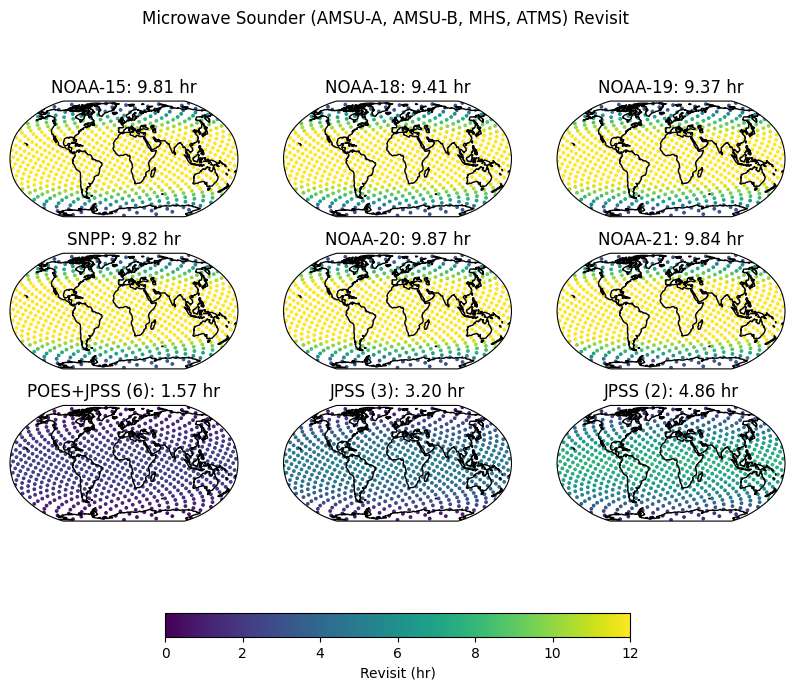

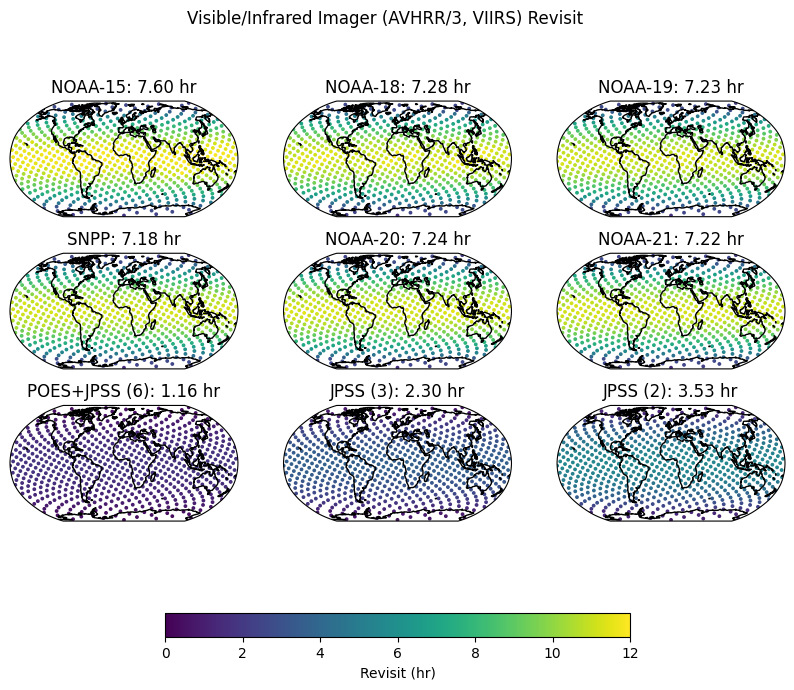

In [22]:
from tatc.analysis import aggregate_observations, reduce_observations
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from scipy import stats

min_revisit = 0
max_revisit = 12


def plot_harmonic_mean_revisit(instrument_group):
    inst_label, instruments = instrument_group
    fig, axs = plt.subplots(
        3, 3, figsize=(10, 8), subplot_kw={"projection": ccrs.Robinson()}
    )

    for i, satellite_group in enumerate(satellite_groups):
        sat_label, satellites = satellite_group
        ax = axs[i // 3, i % 3]
        # aggregate observations to combine overlapping observations
        agg_df = aggregate_observations(
            obs_df[
                obs_df.satellite.isin(satellites) & obs_df.instrument.isin(instruments)
            ]
        )
        # reduce observations to time-averaged statistics for each sample point
        red_df = reduce_observations(agg_df)
        red_df["revisit_hr"] = red_df.apply(
            lambda r: r["revisit"] / timedelta(hours=1), axis=1
        )
        # plot the temporally-averaged spatial statistics
        ax.set_title(f'{sat_label}: {stats.hmean(red_df["revisit_hr"]):.2f} hr')
        red_df.plot(
            ax=ax,
            column="revisit_hr",
            cmap="viridis",
            vmin=min_revisit,
            vmax=max_revisit,
            markersize=3,
            transform=ccrs.PlateCarree(),
        )
        ax.coastlines()
        ax.set_global()
    fig.suptitle(f"{inst_label} ({', '.join(instruments)}) Revisit")
    # add a shared colorbar
    fig.colorbar(
        plt.cm.ScalarMappable(
            cmap="viridis", norm=plt.Normalize(vmin=min_revisit, vmax=max_revisit)
        ),
        ax=axs,
        shrink=0.6,
        orientation="horizontal",
        label="Revisit (hr)",
    )
    return fig


figs = Parallel(n_jobs=-1)(
    delayed(plot_harmonic_mean_revisit)(
        instrument_group,
    )
    for instrument_group in instrument_groups
)

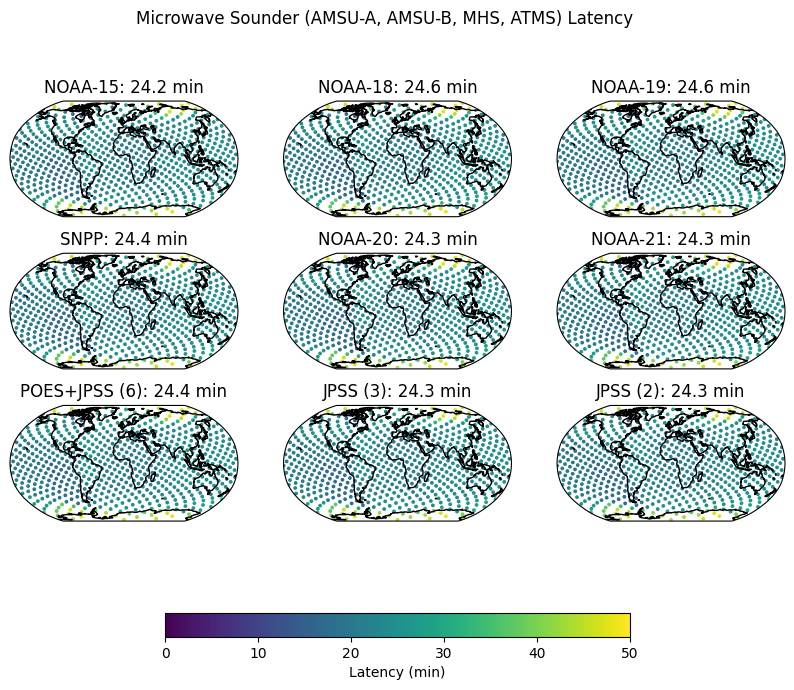

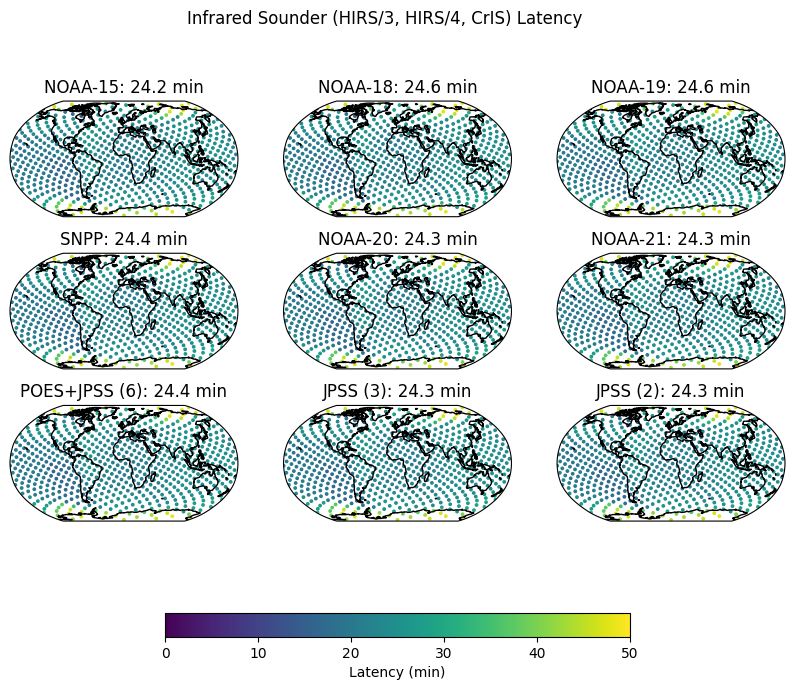

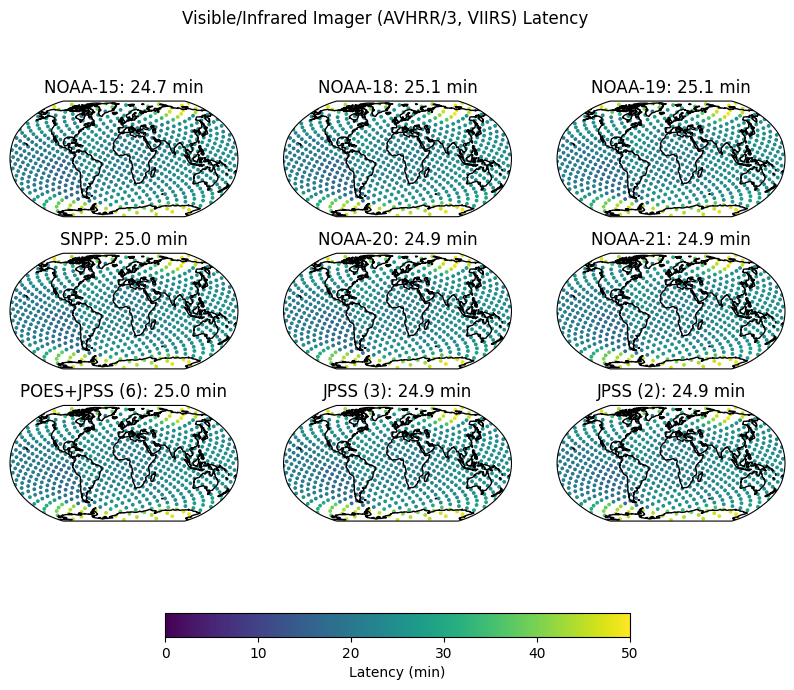

In [23]:
from tatc.analysis import reduce_latencies
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

min_latency = 0
max_latency = 50


def plot_mean_latency(instrument_group):
    inst_label, instruments = instrument_group
    fig, axs = plt.subplots(
        3, 3, figsize=(10, 8), subplot_kw={"projection": ccrs.Robinson()}
    )

    for i, satellite_group in enumerate(satellite_groups):
        sat_label, satellites = satellite_group
        ax = axs[i // 3, i % 3]
        # reduce observations to time-averaged statistics for each sample point
        red_df = reduce_latencies(
            lat_df[
                lat_df.satellite.isin(satellites) & lat_df.instrument.isin(instruments)
            ]
        )
        red_df["latency_min"] = red_df.apply(
            lambda r: r["latency"] / timedelta(minutes=1), axis=1
        )
        # plot the temporally-averaged spatial statistics
        ax.set_title(f'{sat_label}: {red_df["latency_min"].mean():.1f} min')
        red_df.plot(
            ax=ax,
            column="latency_min",
            cmap="viridis",
            vmin=min_latency,
            vmax=max_latency,
            markersize=3,
            transform=ccrs.PlateCarree(),
        )
        ax.coastlines()
        ax.set_global()
    # add a super title
    fig.suptitle(f"{inst_label} ({', '.join(instruments)}) Latency")
    # add a shared colorbar
    fig.colorbar(
        plt.cm.ScalarMappable(
            cmap="viridis", norm=plt.Normalize(vmin=min_latency, vmax=max_latency)
        ),
        ax=axs,
        shrink=0.6,
        orientation="horizontal",
        label="Latency (min)",
    )
    return fig


figs = Parallel(n_jobs=-1)(
    delayed(plot_mean_latency)(
        instrument_group,
    )
    for instrument_group in instrument_groups
)